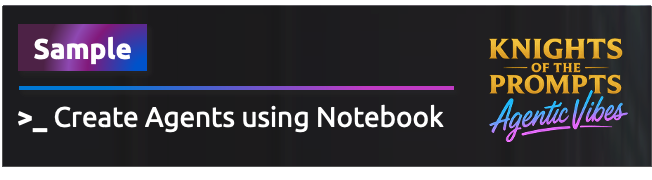
# Lab: Create AI Agent using a Jupyter Notebook

This lab guides you through the process of building a simple AI agent using Azure AI Agents Service SDK. You will learn how to connect to your Azure AI project, create an agent with code interpretation capabilities, and interact with the agent to generate a bar chart from provided data. By the end of this lab, you’ll understand the basics of agent creation, message threading, and file retrieval in the Azure AI ecosystem.

#### Step 1: Load packages

In [4]:
import os
from typing import Any
from pathlib import Path
from dotenv import load_dotenv
from azure.ai.projects import AIProjectClient
from azure.core.credentials import AzureKeyCredential
from azure.identity import DefaultAzureCredential
from azure.ai.agents.models import CodeInterpreterTool # previously in azure.ai.projects.models

load_dotenv() # Load environment variables from .env file

True

#### Step 2: Connect to your Azure AI Foundry project

In [5]:
# Connect to Azure AI Foundry project using DefaultAzureCredential, a type of token-based authentication.
project = AIProjectClient(
    endpoint=os.getenv("AIPROJECT_ENDPOINT"),
    credential=DefaultAzureCredential()
)

#### Step 3: Create the simple AI Agent

This step demonstrates how to use the Azure AI Agents SDK to create and interact with an AI agent that can interpret code. The process includes:
- Initializing a code interpreter tool and creating an agent with it.
- Creating a communication thread for the agent.
- Sending a message to the agent with a request to generate a bar chart from provided health plan data.
- Running the agent and monitoring the run status.
- Retrieving and displaying all messages in the thread, and downloading any generated image file.
- Cleaning up by deleting the agent after the process is complete.

This workflow shows how to automate data analysis and visualization tasks using conversational AI agents in Azure.

In [ ]:
code_interpreter = CodeInterpreterTool()
with project:
    # Create an agent with the CodeInterpreterTool
    agent = project.agents.create_agent(
        model=os.environ["CHAT_MODEL"],
        name="my-agent",  # Name of the agent
        instructions="You are a helpful agent",  # Instructions for the agent
        tools=code_interpreter.definitions,
    )
    print(f"Created agent, ID: {agent.id}")

    # Create a thread for communication
    thread = project.agents.threads.create()
    print(f"Created thread, ID: {thread.id}")
    
    # Add a message to the thread
    message = project.agents.messages.create(
        thread_id=thread.id,
        role="user",
        content=(
            "Could you please create a bar chart for the using the following data and provide the file to me? "
            "Name the file as health-plan-comparision.png.\n\n"
            "Here is the data:\n"
            "Provider        Monthly Premium    Deductible    Out-of-Pocket Limit\n"
            "Northwind       $300               $1,500        $6,000\n"
            "Aetna           $350               $1,000        $5,500\n"
            "United Health   $250               $2,000        $7,000\n"
            "Premera         $200               $2,200        $6,500\n"
        ),
    )
    print(f"Created message, ID: {message['id']}")
    
    # Create and process an agent run
    run = project.agents.runs.create_and_process(thread_id=thread.id, agent_id=agent.id)
    print(f"Run finished with status: {run.status}")
    
    # Check if the run failed
    if run.status == "failed":
        print(f"Run failed: {run.last_error}")
    
    # Fetch and log all messages
    messages = project.agents.messages.list(thread_id=thread.id)
    print("Conversation:")
    found_file = False
    for msg in messages:
        print(f"{msg.role}: {msg.content}")
        if hasattr(msg, "file_path_annotations") and msg.file_path_annotations:
            for file_path_annotation in msg.file_path_annotations:
                file_name = Path(file_path_annotation.text).name
                file_content = project.agents.files.get_content(file_id=file_path_annotation.file_path.file_id)
                with open(file_name, "wb") as f:
                    for chunk in file_content:
                        f.write(chunk)
                print(f"Saved image file to: {Path.cwd() / file_name}")
                found_file = True
    if not found_file:
        print("No image file was generated by the agent.")
    
    # Delete the agent when done
    project.agents.delete_agent(agent.id)
    print("Deleted agent")